## Loading up packages

In [1]:
# Let the program know where to find your tools file.
import sys
sys.path.append('/home/keeganfl/Desktop/Work_Fall_2021/Fall_2021_Work_journal/tools/')

In [2]:
# import plastid
# data structure for mapping read alignments to genomic positions
from plastid import BAMGenomeArray, VariableFivePrimeMapFactory, \
                        GTF2_TranscriptAssembler, GFF3_TranscriptAssembler, \
                        Transcript, ThreePrimeMapFactory
import numpy as np
import os
from Bio import SeqIO
import numpy
import math
import pandas as pd
from scipy import stats
from scipy.stats import kstwo
import keegan_analysis_tools as kat
from statsmodels.nonparametric.smoothers_lowess import lowess
import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import csv
from scipy.sparse.linalg import lsqr
from tqdm import tqdm
from multiprocess import Pool
from magic_functions import process_frame

In [3]:
# Define the path to our Bam files
data_path = '/home/keeganfl/Desktop/Work_Fall_2021/genomes_&_samples/ecol/'
csv_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/position_counts/ecol/'
elon_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/elongation_rates/ecol/'
save_path = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/KS_stats/ecol/'
save_path2 = '/home/keeganfl/Desktop/Work_Fall_2021/data_tables/TASEP-KS/ecol/'
gtf_name = 'Escherichia_coli_str_k_12_substr_mg1655_gca_000005845.ASM584v2.51.gtf'
mutation = 'efp'
samp_num = '2'
if os.path.isfile(save_path + "ks_table_" + samp_num + ".csv") == True:
    pre_load = True
else:
    pre_load = False

## Loading up the data files 

In [4]:
# load the transcript annotations from the GTF file.
# GTF2_TranscriptAssembler returns an iterator, so here we convert it to a list.
transcripts = list(GTF2_TranscriptAssembler(open(data_path + gtf_name),return_type=Transcript))

In [5]:
# Remove non-protein coding transcripts from transcripts list. 
protein_coding = []
for transcript in transcripts:
    if transcript.attr['gene_biotype'] == 'protein_coding':
        protein_coding.append(transcript)

In [6]:
# clear up some memory by deleting original transcript list
transcripts.clear()

# Loading up the csv file.

In [7]:
# Load in the count positions data.
data_mutant = kat.load_count_positions(mutation+"_RPF_"+samp_num+"_counts.csv",csv_path)
data_control = kat.load_count_positions("control_RPF_"+ samp_num +"_counts.csv",csv_path)

In [8]:
# Load in the elongation rates data.
elon_mutant = kat.load_elongation_rates(mutation + '_' + samp_num + '_elongation_rates', elon_path)
elon_control = kat.load_elongation_rates('control' + '_' + samp_num + '_elongation_rates', elon_path)

## Define functions

In [9]:
# Calculate the smoothed density vector pbar for xth entry with length n-9
def get_pbar_from_count(tr_m):
    M = sum(tr_m)
    p = tr_m/M
    x=0
    pbar=[]
    for px in p:
        pbar_x = 0.1*sum(p[x:x+10]) #it is x+10 not x+9 because python does not include the final index.
        pbar.append(pbar_x)
        x = x+1
        if x  == len(p)-9:
            break
    pbar = np.array(pbar)
    return(pbar)

## Calculate Smoothed Vector Arrays

In [10]:
max_pool = 20

if pre_load == False:
    with Pool(max_pool) as p:
        pool_control = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       data_control),
                total=len(data_control)
            )
        )    

In [11]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_mutant = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       data_mutant),
                total=len(data_mutant)
            )
        )    

## Determine KS statistic for all transcripts

In [12]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    gene_list = []
    tr_id = []
    len_list = []
    for tr_m, tr_c, transcript, index in zip(data_mutant, data_control, protein_coding, list(range(len(data_mutant)))):
        # Only Calculate KS statistics for genes with decent length and read density
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.15 and sum(tr_c)/len(tr_c) > 0.15:
            position = np.array(list(range(len(tr_m))))
            smoothed_vec_m, cumul_m = pool_mutant[index]
            smoothed_vec_c, cumul_c = pool_control[index]
            ks = max(abs(cumul_m - cumul_c))
            ks_list.append(ks)
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())
            len_list.append(len(tr_m))
            
    # reorganizing the lists into a dataframe. 
    df_b = pd.DataFrame(list(zip(gene_list, tr_id, ks_list, len_list)))
    df_b.columns = ["gene_ID","transcript_ID", "ks_stat", "gene_length"]
    df_b.to_csv(save_path + "ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    len_list.clear()
    pool_mutant.clear()
    pool_control.clear()

In [13]:
# An optional line that loads up a pre-made dataset
if pre_load == True:
    df_b = pd.read_csv(save_path + "ks_table_" + samp_num + ".csv")

(0.0, 0.7)

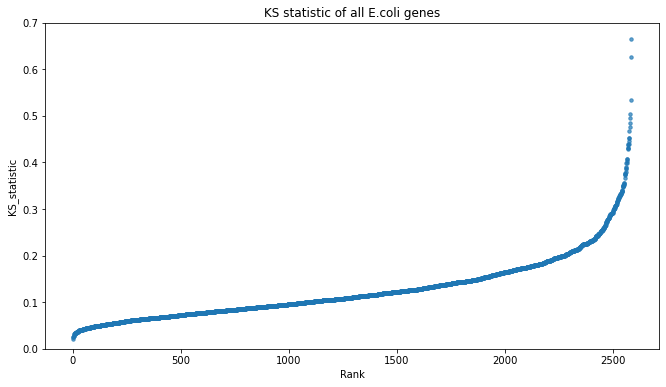

In [121]:
# Plot the KS values for each gene from lowest to highest. 
figure(figsize = (11,6))
plt.scatter(list(range(len(df_b["ks_stat"]))), sorted(df_b["ks_stat"]), s=12, alpha = 0.7)
plt.ylabel("KS_statistic")
plt.xlabel("Rank")
plt.title("KS statistic of all E.coli genes")
plt.ylim(0,0.7)

#### Alright, now how do I bin these by gene length? Quick thought, would I be able to filter out those ones I really don't like by just saying that if the maximum value is nearly equal to the sum of the entire transcript then do not count it? maybe it would not be good to cut all of that out. 

In [15]:
# Create a column in the data frame containing the size group for each gene.
size_groups = []
for i in df_b["gene_length"]:
    if i < 700:
        size_groups.append(1)
    elif i >= 700 and i < 1750:
        size_groups.append(2)
    elif i >= 1750:
        size_groups.append(3)
df_b["size_groups"] = size_groups

In [16]:
# Find all of the transcripts with a KS stat above a certain threshold and group them by gene ID
group = df_b[(df_b['ks_stat'] > 0.40) & (df_b['size_groups'] == 1)].groupby('gene_ID')

# Create a list of all of the unique genes 
diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [17]:
len(diff_dist)

8

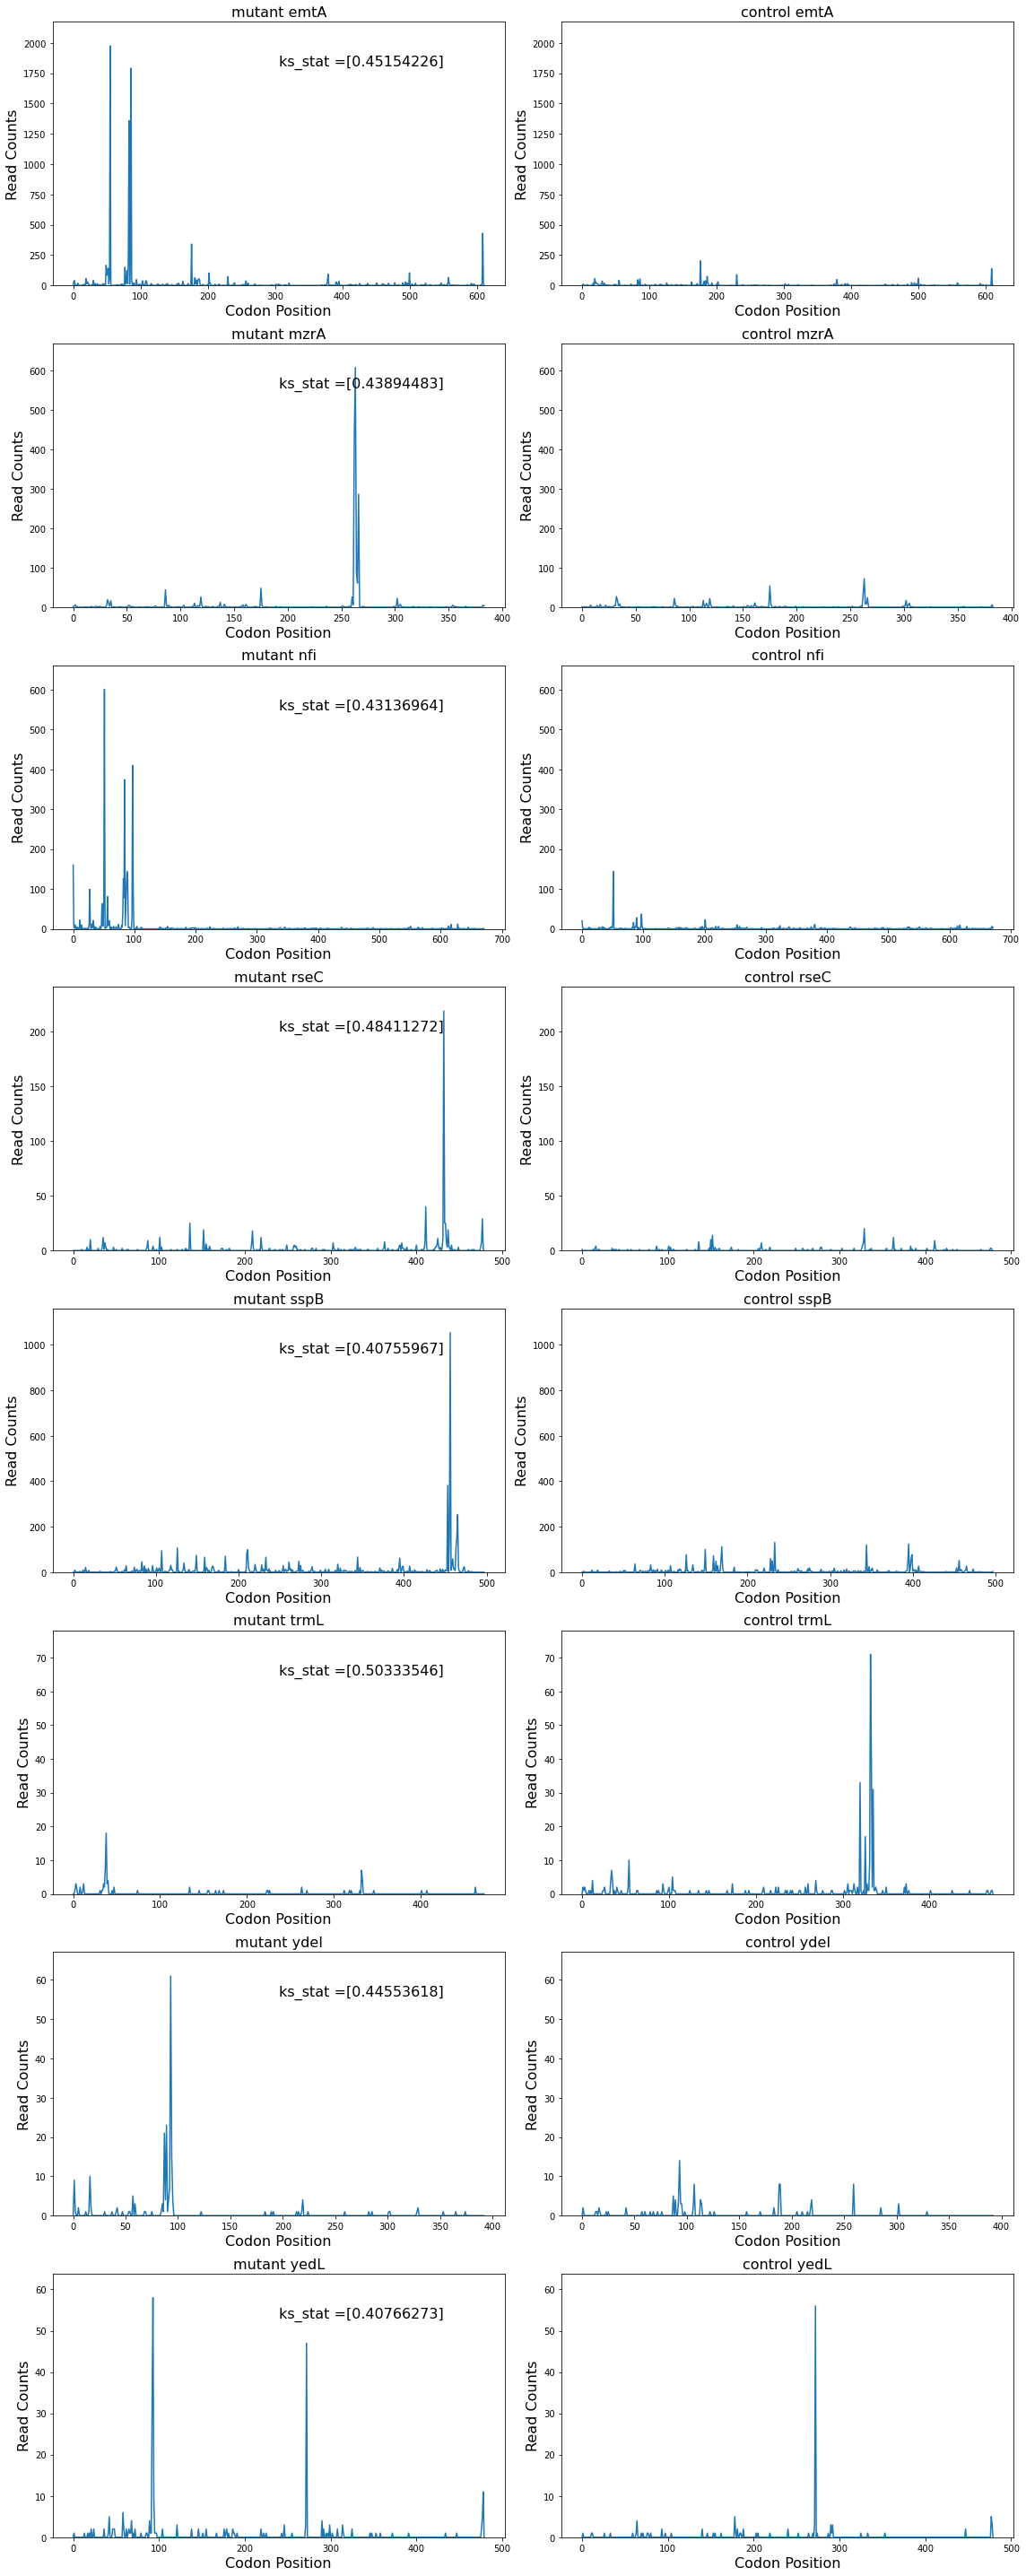

In [18]:
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,40), fontsize = 16)

## Tasep-KS method

In [19]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    alt_p_list = []
    pbar_m_list = []
    gene_list = []
    tr_id = []
    for tr_m, tr_c, el_m, el_c, transcript in zip(data_mutant, data_control, elon_mutant, elon_control, protein_coding):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            alt_p_list.append(kat.alter_p(el_c, el_m))
            pbar_m_list.append(get_pbar_from_count(tr_m))
            gene_list.append(transcript.attr["gene_name"])
            tr_id.append(transcript.get_name())

In [20]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_alt_p = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       alt_p_list),
                total=len(alt_p_list)
            )
        )    

In [21]:
if pre_load == False:
    with Pool(max_pool) as p:
        pool_pbar_m = list(
            tqdm(
                p.imap(kat.get_smoothed_vector_parallel,
                       pbar_m_list),
                total=len(pbar_m_list)
            )
        )    

In [22]:
# Find the correlation between all of the controls and the samples.
# Note that many of the lowest values spring from very short transcripts or transcripts with few reads. 
if pre_load == False:
    ks_list = []
    for pbar_m, alt_p in zip(pool_pbar_m, pool_alt_p):
        if len(tr_m) > 200 and sum(tr_m)/len(tr_m) > 0.5 and sum(tr_c)/len(tr_c) > 0.5 and sum(el_c) > 0 and sum(el_m) > 0:
            sm_m, cumul_m = pbar_m
            sm_p, cumul_p = alt_p
            for d, i in zip(sm_m, list(range(len(sm_m)))):
                if d < 0:
                    sm_m[i] = 0.000000000000000000001
            ks = max(abs(cumul_p - cumul_m))
            ks_list.append(ks)
            
    # reorganizing the lists into a dataframe. 
    df_t = pd.DataFrame(list(zip(gene_list, tr_id, ks_list)))
    df_t.columns = ["gene_ID","transcript_ID", "ks_stat"]
    df_t.to_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv", index=False)
    
    # Clear out unneeded lists
    ks_list.clear()
    gene_list.clear()
    tr_id.clear()
    alt_p_list.clear()
    pbar_m_list.clear()
    pool_alt_p.clear()
    pool_pbar_m.clear()

In [24]:
if pre_load == True:
    df_t = pd.read_csv(save_path2 + "TASEP_ks_table_" + samp_num + ".csv")

Text(0.5, 1.0, 'KS Statistic')

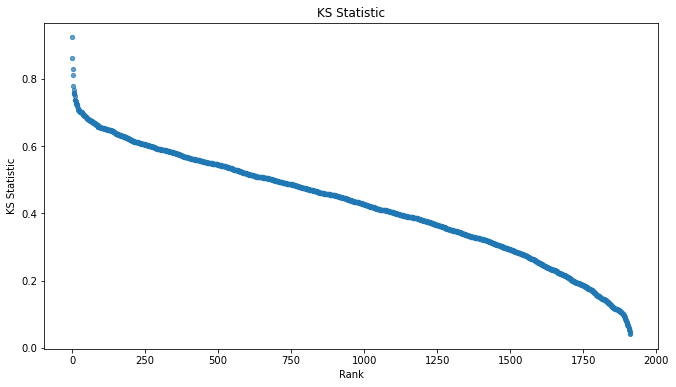

In [25]:
figure(figsize = (11,6))
plt.scatter(list(range(len(df_t["ks_stat"]))), sorted(df_t["ks_stat"], reverse = True), s=18, alpha = 0.7)
plt.ylabel("KS Statistic")
plt.xlabel("Rank")
plt.title("KS Statistic")

In [26]:
group = df_t[(df_t['ks_stat'] > 0.2) & (df_t['ks_stat'] < 0.205)].groupby('gene_ID')

diff_dist = group.apply(lambda x: x['ks_stat'].unique())

In [27]:
len(diff_dist)

6

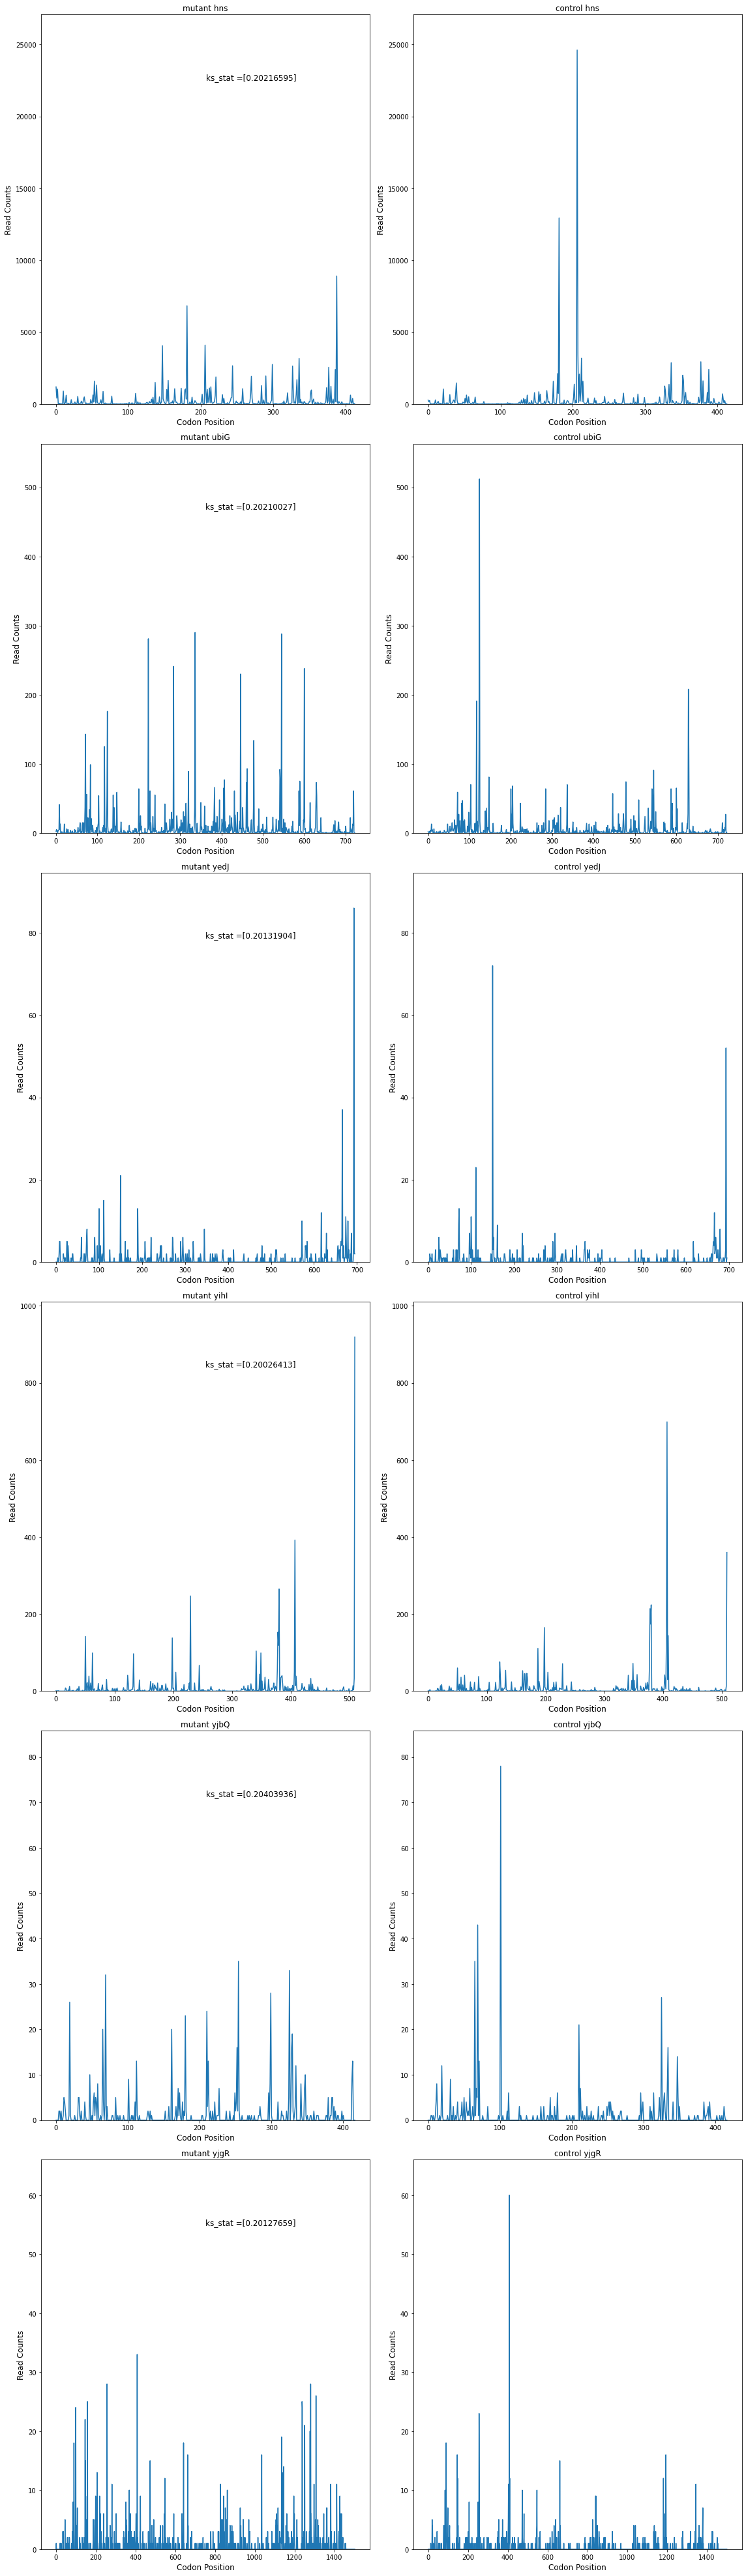

In [28]:
ax = kat.big_dif(diff_dist, protein_coding, data_mutant, data_control, figsize = (16,30), fontsize = 12)

## Test Area

In [85]:
wool_table = pd.read_csv('/home/keeganfl/Desktop/Work_Fall_2021/data_tables/Woolstenhulme_table.csv')

In [87]:
wool_table[wool_table["Gene"] == "cdd"]

,Rank,Gene,RRO,AS,MS_WT/EFP
8,9,cdd,7.72,1.4,0.68


In [88]:
ms_compare = pd.merge(wool_table, df_b, how='inner', left_on='Gene', right_on='gene_ID')

In [95]:
ms_compare[ms_compare["Gene"] == "cdd"]["MS_WT/EFP"]

4    0.68
Name: MS_WT/EFP, dtype: object

In [40]:
len(ms_compare)

101

In [91]:
ms_compare = ms_compare[ms_compare['MS_WT/EFP'] != "nd"]
ms_compare = ms_compare.reset_index()

In [93]:
for ms,i in zip(ms_compare["MS_WT/EFP"], list(range(len(ms_compare["MS_WT/EFP"])))):
    ms_compare["MS_WT/EFP"][i] = float(ms)

---------------------------------------------------------------------------
SettingWithCopyWarning

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
in /tmp/ipykernel_276051/3256983014.py, line 2:

1 for ms,i in zip(ms_compare["MS_WT/EFP"], list(range(len(ms_compare["MS_WT/EFP"])))):
2     ms_compare["MS_WT/EFP"][i] = float(ms)

---------------------------------------------------------------------------


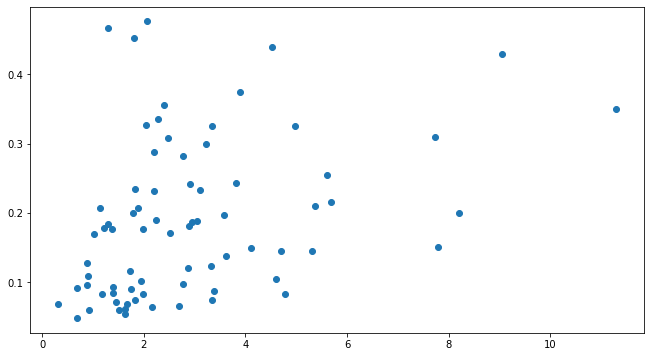

In [96]:
figure(figsize = (11,6))
plt.scatter(ms_compare["MS_WT/EFP"], ms_compare["ks_stat"])

In [110]:
ms_compare.head(20)

,index,Rank,Gene,RRO,AS,MS_WT/EFP,gene_ID,transcript_ID,ks_stat,gene_length,size_groups
0,0,2,cysQ,14.23,14.85,1.81,cysQ,AAC77171,0.452642,741,2
1,3,5,dhaM,8.69,2.06,1.46,dhaM,AAC74282,0.071060,1419,2
2,4,6,pfkB,8.31,6.94,4.11,pfkB,AAC74793,0.149586,930,2
3,5,8,malQ,7.94,2.29,5.36,malQ,AAC76441,0.210104,2085,3
4,6,9,cdd,7.72,1.40,0.68,cdd,AAC75204,0.048011,885,2
5,7,11,acnB,7.37,17.49,4.53,acnB,AAC73229,0.439214,2598,3
6,8,12,rnb,7.14,13.00,11.3,rnb,AAC74368,0.349813,1935,3
7,9,14,ybhB,5.97,5.69,2.19,ybhB,AAC73860,0.230878,477,1
8,10,15,ybiU,5.80,5.61,7.8,ybiU,AAC73908,0.150163,1266,2
9,11,16,poxB,5.79,11.30,2.39,poxB,AAC73958,0.355677,1719,2


## Choose a gene of interest and observe the smooth and unsmooth array.

In [111]:
# Choosing a gene of interest to calculate the elongation rates of. 
# Get the transcript and vector for the gene of interest.
my_gene = 'qorA'
my_transcript, my_vec_mutant, my_vec_control, index = kat.find_transcripts(my_gene, 
                                           protein_coding, data_mutant, data_control)

In [112]:
# Create a vector that just reflects the positions along the transcript
my_position = np.array(list(range(len(my_vec_mutant))))

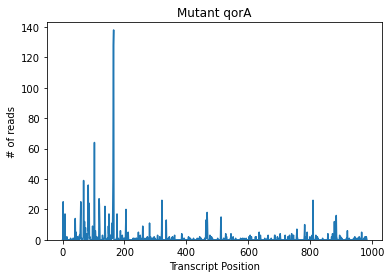

Text(0.5, 1.0, 'Control qorA')

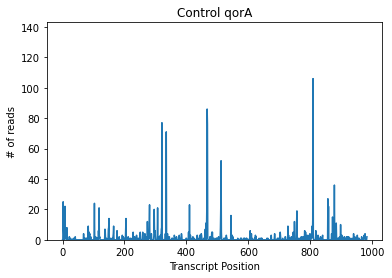

In [113]:
maxi = max([max(my_vec_mutant), max(my_vec_control)])

plt.plot(my_vec_mutant)
plt.ylim([0,maxi+5])
plt.ylabel("# of reads")
plt.xlabel("Transcript Position")
plt.title("Mutant " + my_gene)
plt.show()
plt.plot(my_vec_control)
plt.ylim([0,maxi+5])
plt.ylabel("# of reads")
plt.xlabel("Transcript Position")
plt.title("Control " + my_gene)

In [114]:
smoothed_vec_m, cumul_m = kat.get_smoothed_vector(my_position, my_vec_mutant+0.00000000001)
smoothed_vec_c, cumul_c = kat.get_smoothed_vector(my_position, my_vec_control+0.00000000001)

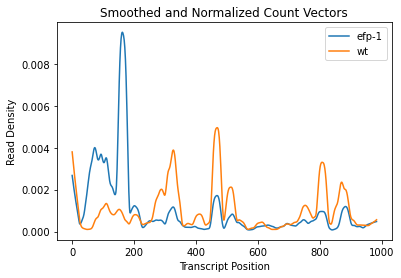

In [115]:
plt.plot(smoothed_vec_m, label = "efp-1")
#plt.plot(my_vec_mutant/sum(my_vec_mutant))
plt.plot(smoothed_vec_c, label = "wt")
plt.ylabel("Read Density")
plt.xlabel("Transcript Position")
plt.title("Smoothed and Normalized Count Vectors")
plt.legend()

## Plot and calculate the correlation of the cumulative sum * The transcript position

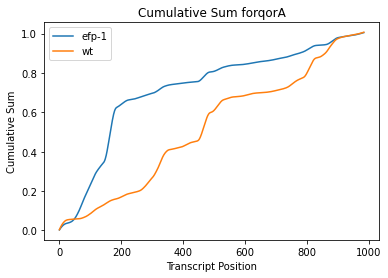

In [116]:
plt.plot(my_position, cumul_m, label = "efp-1")
plt.plot(my_position, cumul_c, label = "wt")
plt.ylabel("Cumulative Sum")
plt.xlabel("Transcript Position")
plt.title("Cumulative Sum for" + my_gene)
plt.legend()

In [117]:
ks = max(abs(cumul_m - cumul_c))
ks

0.47644174957099394